In [1]:
import sympy as sym
import numpy as np
import math
import scipy.linalg as la 
import matplotlib.pyplot as plt
import networkx as nx
from numpy.linalg import inv
import pandas as pd

In [2]:
t = sym.Symbol('t', real=True)
x = sym.Symbol('x', real=True)
pi = np.pi

In [3]:
np.random.seed(10)

In [4]:
def matrix_exp(H):
    """Function that takes in a matrix and returns the matrix exponential"""
    eigvals, eigvecs = la.eig(H)
    diag_vals = []
    for i in range(len(eigvals)):
        diag_vals.append(sym.exp(1j*eigvals[i]*t))
    W = eigvecs
    X = inv(W)
    D = sym.diag(*diag_vals)
    M = sym.Matrix(W)*D*sym.Matrix(X)
    return M 

In [5]:
def line(N):
    """Function that generates the adjacency matrix for a line of N nodes"""
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    return H 

def loop(N):
    """Function that generates the adjacency matrix for a loop of N nodes"""
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    H[0][N-1] = 1
    H[N-1][0] = 1
    return H 

def k_connected(N):
    """Function that generates the adjacency matrix for a k-connected graph of N nodes"""
    H = np.ones((N,N))
    for i in range(N):
        H[i][i] = 0
    return H 

def mobius(N):
    graph = nx.moebius_kantor_graph()
    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    return H 

def plot_graph(graph,N):
    """A function that takes in a graph function and the size to returns a plot of the graph"""
    H = graph(N)
    A = nx.from_numpy_matrix(np.array(H))  
    nx.draw_circular(A, with_labels=True)
    plt.title(f'{graph.__name__} Graph')
    plt.show()

In [6]:
def probability_distribution(H, start_node, final_node, time_array):
    """A function that takes in an adjacency matrix, the start and finish nodes and the time array and generates the probability distribtution and analytical probability function"""
    M = matrix_exp(H)
    Y = M*sym.Matrix(start_node)
    Z = sym.Matrix(final_node).dot(Y)

    F_p = sym.Abs(sym.simplify(Z))**2
    P = []
    for i in range(len(time_array)):
        p = F_p.evalf(subs={t:time_array[i]})
        P.append(sym.Abs(p))
      
    return P, F_p

def fisher_info(F_p, time_array):
    """A function that takes in an analytical probability function and time array and returns the fisher information with time as an array"""
    F = []
    df = sym.diff(F_p, t)
    f = sym.simplify((df**2)/(F_p))
    for i in range (len(time)):
        fi = f.evalf(subs={t:time_array[i]})
        F.append(sym.Abs(fi)) 
    return F

In [7]:
def produce_data(P,n,set_val):
    """A function that takes an array of probability functions, the number of data points produced and a set value as parameter and returns the randomly sampled data array"""
    N = len(P)
    Pe = np.zeros(N)
    for i in range(N):
        Pe[i] = sym.re(P[i].evalf(subs={t:set_val}))
    nodes = np.arange(N)
    M = np.zeros(N)
    for i in range(n):
        d = np.random.choice(nodes, p=Pe)
        M[d] += 1
    return M 

def MLF(P,M):
    """A function that takes an aray of probability functions and sampled data and returns the analytical maximum liklihood function"""
    mlf = 1
    for i in range(len(P)):
        mlf = mlf*(P[i]**int(M[i]))
    return mlf

In [8]:
def get_max(F, X):
    """A function that takes in a y (F) and x arrays and returns its maximum values as an array"""
    max_vals = []
    for i in range(1, len(X)-1):
        f_low = sym.Abs(F.subs(t,X[i-1]))
        f = sym.Abs(F.subs(t,X[i]))
        f_high = sym.Abs(F.subs(t,X[i+1]))
        if f_low < f and f_high < f:
            max_vals.append(X[i])
    return max_vals

In [9]:
def get_max_2(F, X):
    """A function that takes in a y (F) and x arrays and returns one maximum values"""
    K = 0
    J = 0
    for j in range(len(X)):
        k = sym.re(F.evalf(subs={t:X[j]}))
        if k > K:
            K = k
            J = j
    return X[J]

In [10]:
def produce_nodes(N):
    """A function that takes in a size N and returns an array of node vectors"""
    node = np.zeros(N)
    nodes = []
    for i in range(N):
        node[i] = 1
        nodes.append(node)
        node = np.zeros(N)
    return nodes

In [11]:
def produce_probs_fish(H, node_i):
    """A function that takes in an adjacency matrix and starting node and produces the probability and fisher arrays with time (undefined) and returns the analytical probabilty function array"""
    N = len(H)
    nodes = produce_nodes(N)
    probs = []
    pf = []
    fish = []
    for j in range(N):
        probi, pfi = probability_distribution(H, nodes[node_i], nodes[j], time)
        fi = fisher_info(pfi, time)
        probs.append(probi)
        pf.append(pfi)
        fish.append(fi)
    return probs, pf, fish

C = ['navy','firebrick','darkorange','gold','springgreen','magenta', 'aqua', 'forestgreen']

def fock_plot(H, node_i):
    """A function that takes in an adjacency matrix and starting node and produces the plot of the probability distribution and fisher information with time"""
    N = len(H)
    probs, pf, fish = produce_probs_fish(H, node_i)
    fig, ax = plt.subplots(2, figsize=(10,10))
    fig.suptitle(f"Fock State on {N} Nodes")

    ax[0].set(ylabel="Probability")

    thickness = np.linspace(1,3,N)

    for i in range(N):
        ax[0].plot(time, probs[i], label = f'Node {i}', c=C[i], linewidth=thickness[N-i-1])
        ax[1].plot(time, fish[i], label = f'Node {i}', c=C[i], linewidth=thickness[N-i-1])

    ax[1].set(xlabel='Time (s)', ylabel='Fisher Information')
    ax[1].plot(time, np.sum(fish, axis=0), label ="Total", c='darkviolet')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [12]:
def find_nearest(array, value):
    """A function that takes in an array and a value and returns the index of the nearest in the array to the value"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [13]:
def MLE_plot_single(H, node_i, set_val):
    """A function that takes in an adjacency matrix,starting node and parameter value and plots a single maximum liklihood function using standard N=50 for producing data"""
    probs, pf, fish = produce_probs_fish(H, node_i)
    M = produce_data(pf, 100, set_val)
    mlf = MLF(pf, M)

    mlf_array = []
    for y in time:
        mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
    plt.plot(time,mlf_array)

    max_vals = get_max(mlf,time)
    plt.scatter(set_val,0, marker='x', c='red')
    plt.xlabel('Time (s)')
    plt.show()

In [14]:
def MLE_repeats(H,node_i,n,repeats,set_val,period):
    """A function that takes in an adjacency matrix and starting node, N(n) - number of repeats for data production, repeats - number of times experiment is repeated and set parameter value. The function also takes in a 'period' - this needs to be judged from the probability graph. This returns the mean, variance, time array and array of y arrays for the maximum liklihood functions"""
    probs, pf, fish = produce_probs_fish(H,node_i)
    time_1 = time[:find_nearest(time,period/2)+1]

    data = []
    multiple_mlf = []
    for j in range(repeats):
        M = produce_data(pf, n, set_val)
        mlf = MLF(pf, M)
        mlf_array = []
        for y in time_1:
            mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
        multiple_mlf.append(mlf_array)
        max_vals = get_max_2(mlf,time_1)
        data.append(max_vals)
    mean = np.mean(data)
    var = np.var(data)
    return mean,var,time_1,multiple_mlf

def MLE_plot_mult(mean,var,time,multiple_mlf):
    """This takes in the outputs of MLE_repeats and plots the multiple maximum liklihood functions and the normal distribution associated"""
    fig, ax = plt.subplots(2, figsize=(8,8))
    for j in range(len(multiple_mlf)):
        ax[0].plot(time, multiple_mlf[j])
    ax[0].set(ylabel="Liklihood")
    ax[0].set_title('Maximum Likelihood Estimation Function')
    ax[1].set_title('Normal PDF')
    ax[1].set(xlabel='Time (s)')
    ax[1].plot(time, stats.norm.pdf(time_1, mean, math.sqrt(var)))
    ax[1].scatter(mean,0, marker='x', c='red')
    plt.show()

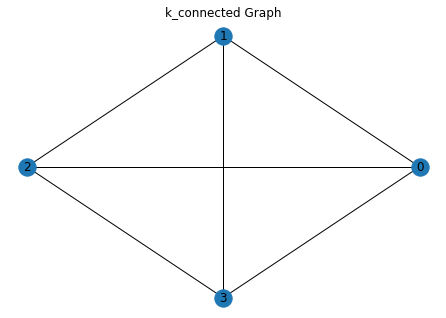

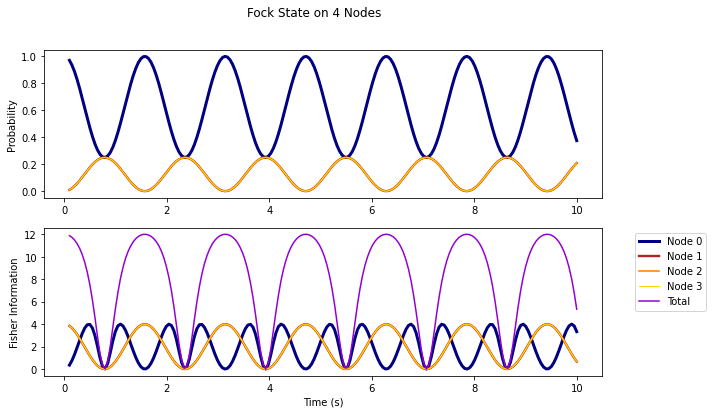

In [15]:
time = np.linspace(0.1,10,200)
plot_graph(k_connected,4)
fock_plot(k_connected(4),0)
#

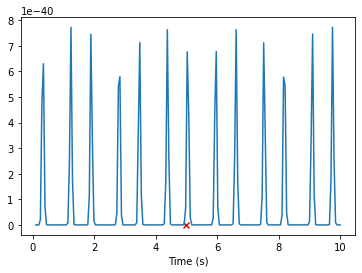

In [47]:
time = np.linspace(0.1,10,200)
MLE_plot_single(k_connected(4),0,5)

In [24]:
time = np.linspace(4.5,5.5,100)
probs, pf, fish = produce_probs_fish(k_connected(4),0)
M = produce_data(pf, 100, 5)
mlf = MLF(pf, M)

mlf_array = []
for y in time:
    mlf_array.append(sym.re(mlf.evalf(subs={t:y})))

max_val = get_max_2(mlf,time)

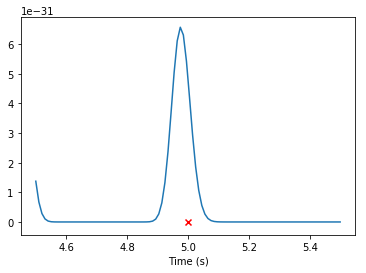

In [33]:
plt.plot(time,mlf_array)
plt.scatter(5,0, marker='x', c='red')
#plt.scatter(max_val,0, marker='x', c='green')
plt.xlabel('Time (s)')
plt.show()

In [26]:
max_val

4.9646464646464645

In [31]:
time = np.linspace(4.5,5.5,100)
probs, pf, fish = produce_probs_fish(k_connected(4),0)
data = []
multiple_mlf = []
np.random.seed(10)
for j in range(30):
    M = produce_data(pf, 100, 5)
    mlf = MLF(pf, M)
    mlf_array = []
    for y in time:
        mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
    multiple_mlf.append(mlf_array)
    max_vals = get_max_2(mlf,time)
    data.append(max_vals)
mean = np.mean(data)
var = np.var(data)

In [32]:
print(mean,var)

4.9986531986532 0.0010780079130247495


In [17]:
probs, pf, fish = produce_probs_fish(k_connected(4),0)
idx = find_nearest([pf[1].evalf(subs={t:i}) for i in time], pf[1].evalf(subs={t:0}))
period4 = time[idx]

In [20]:
period4

7.8608040201005025

In [22]:
period4 = period4/5
print(period4)

1.5721608040201005


In [33]:
time_vals = np.linspace(0.1,2,6)
mean_data =[]
for i in time_vals:
    mean,var,time_1,multiple_mlf = MLE_repeats(k_connected(4),0,100,10,i,period4)
    mean_data.append(mean)

In [34]:
dic1 = {'Time Value': time_vals, 'Predicted': mean_data, '% Error': [round(abs((mean_data[i]-time_vals[i])/time_vals[i])*100,2) for i in range(len(time_vals))]}

In [35]:
pd.DataFrame(dic1)

,Time Value,Predicted,% Error
0,0.10,0.109950,9.95
1,0.48,0.488040,1.68
2,0.86,0.721859,16.06
3,1.24,0.328844,73.48
4,1.62,0.100000,93.83
5,2.00,0.448241,77.59


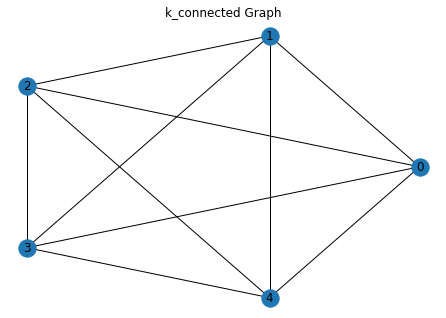

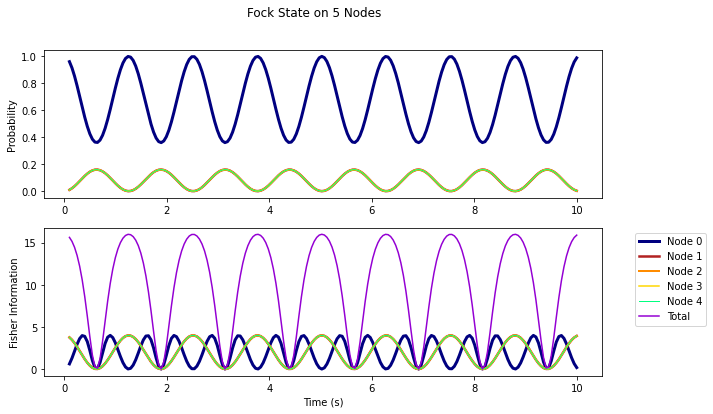

In [16]:
plot_graph(k_connected,5)
fock_plot(k_connected(5),0)

In [23]:
probs, pf, fish = produce_probs_fish(k_connected(5),0)
idx = find_nearest([pf[1].evalf(subs={t:i}) for i in time], pf[1].evalf(subs={t:0}))
period5 = time[idx]

In [24]:
period5

5.025125628140703

In [25]:
period5 = period5/4
print(period5)

1.2562814070351758


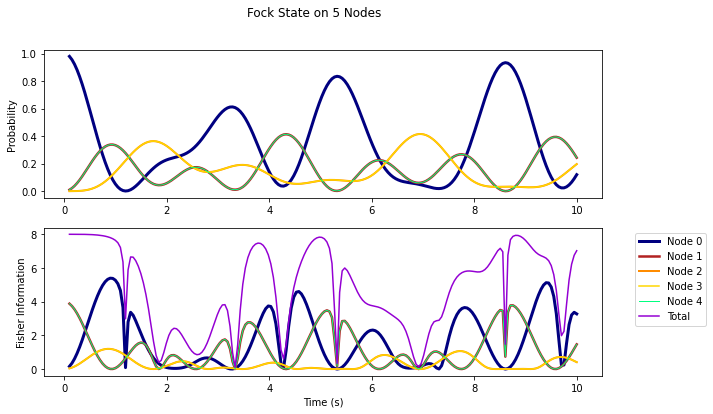

In [29]:
fock_plot(loop(5),0)

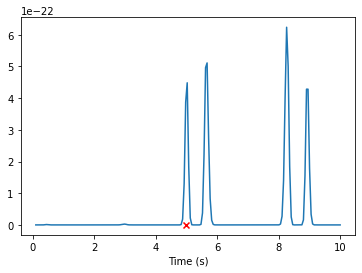

In [36]:
probs, pf, fish = produce_probs_fish(loop(5), 0)
M = produce_data(pf, 50, 5)
mlf = MLF(pf, M)

mlf_array = []
for y in time:
    mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
plt.plot(time,mlf_array)

max_val = get_max_2(mlf,time)
plt.scatter(5,0, marker='x', c='red')
plt.xlabel('Time (s)')
plt.show()

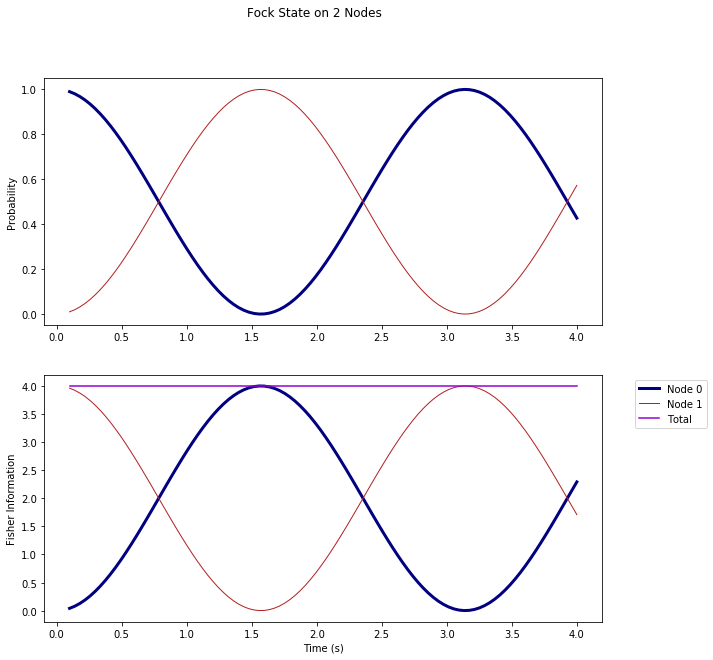

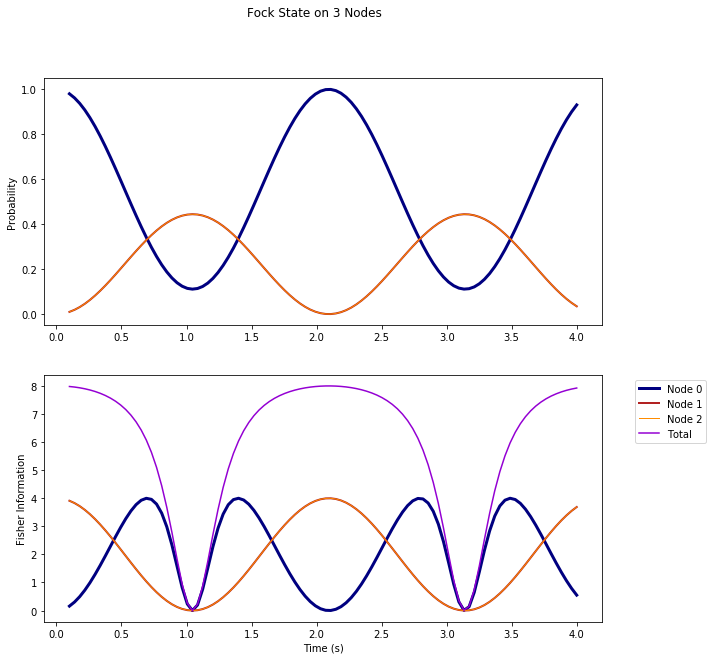

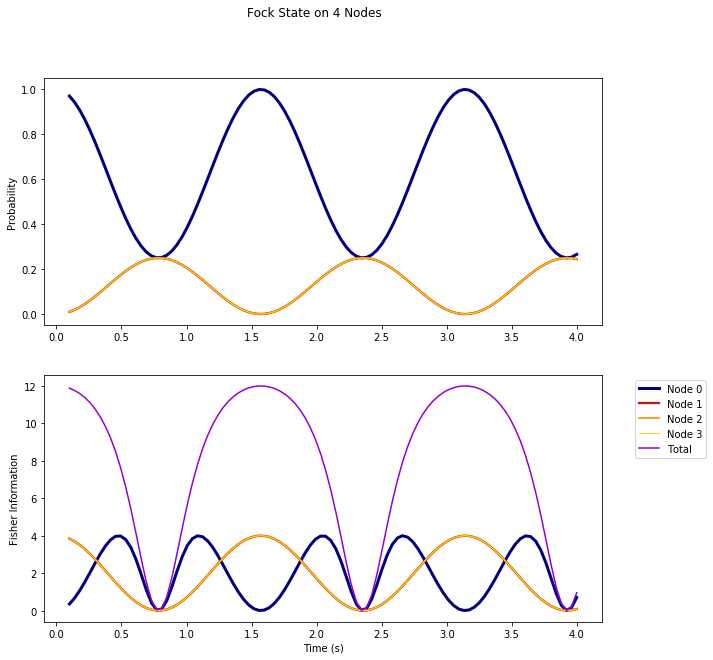

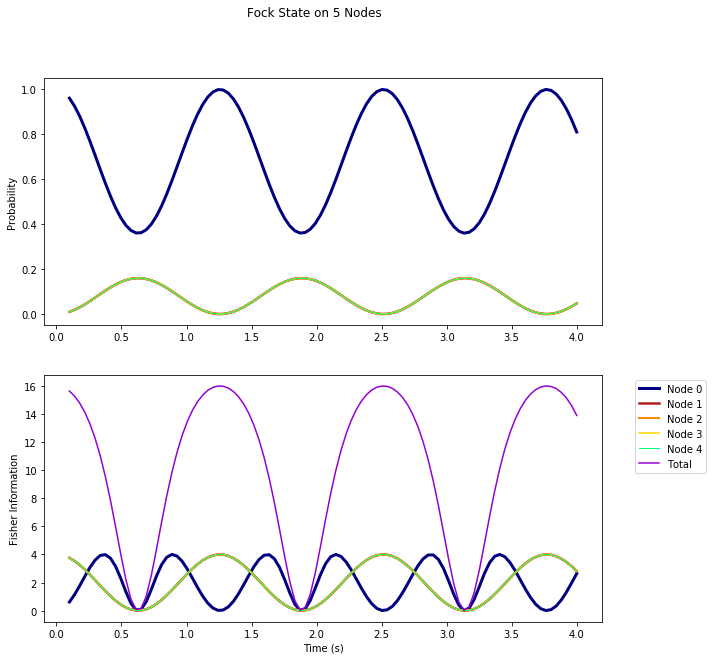

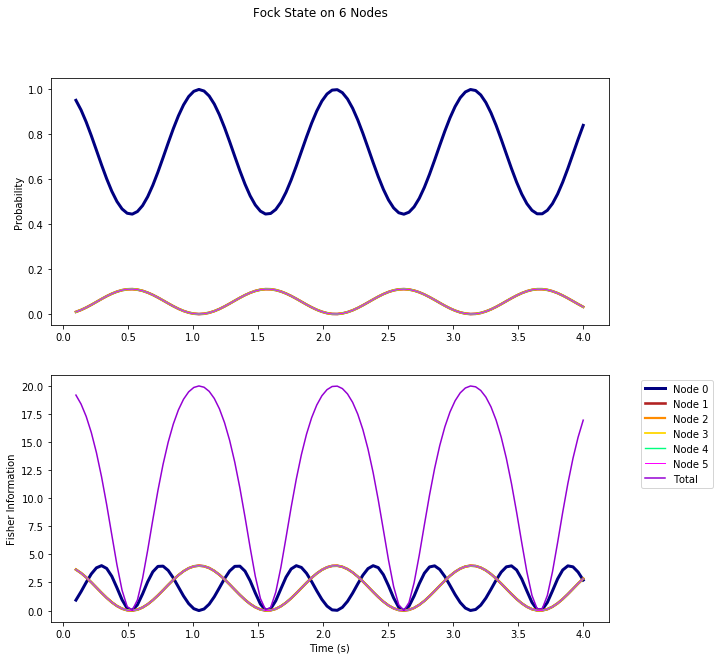

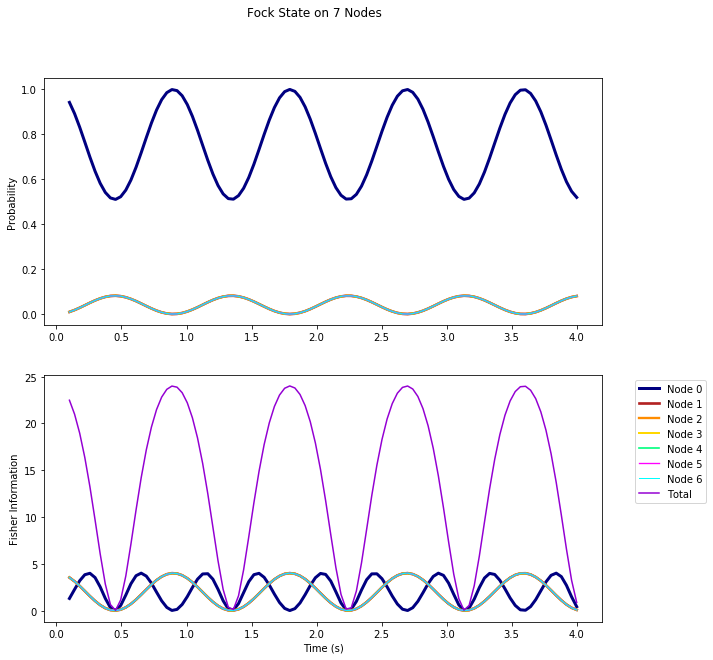

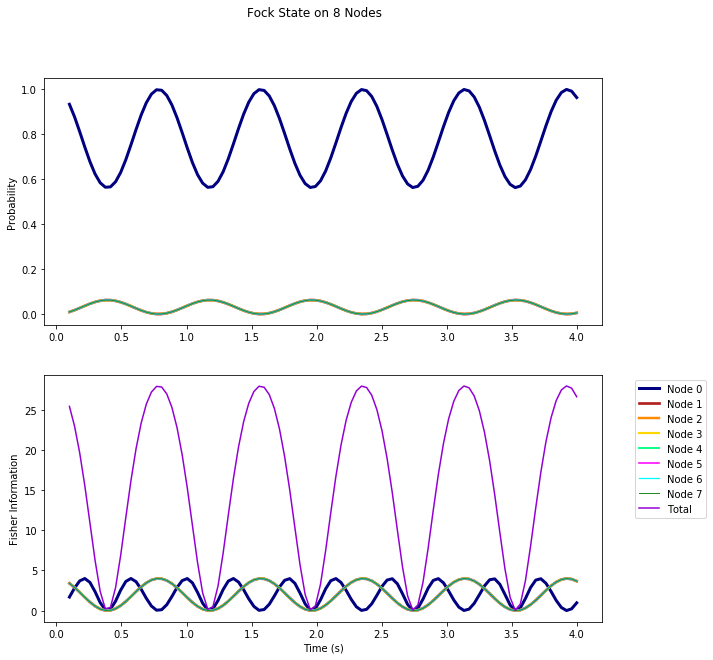

In [55]:
time = np.linspace(0.1,4,100)
for j in range(2,9):
    fock_plot(k_connected(j), 0)

In [19]:
J = []
P = []
MF = []
time = np.linspace(0.1,10,200)
for j in range(3,9):
    J.append(j)
    probs, pf, fish = produce_probs_fish(k_connected(j),0)
    F = np.sum(fish, axis=0)
    max_fish = 0
    for i in F:
        if i > max_fish:
            max_fish = i
    MF.append(max_fish)
    idx = find_nearest([pf[0].evalf(subs={t:i}) for i in time], pf[0].evalf(subs={t:0}))
    period = time[idx]
    P.append(period)

    print(j,period, max_fish)
    print()

3 2.089949748743719 7.99996047668440

4 7.8608040201005025 11.9994414172398

5 5.025125628140703 15.9999271414470

6 1.0452261306532664 19.9996890780085

7 0.8959798994974875 23.9996073086997

8 3.9306532663316585 27.9966197135555



In [20]:
cycles = [1,5,4,1,1,5]
for i in range(len(P)):
    P[i] = P[i]/cycles[i]

In [28]:
d = {'Nodes': J, 'Period (s)': [i.round(2) for i in P]}
pd.DataFrame(d)

,Nodes,Period (s)
0,3,2.09
1,4,1.57
2,5,1.26
3,6,1.05
4,7,0.90
5,8,0.79


In [25]:
d = {'Nodes': J, 'Max Fisher Info': [i.round() for i in MF]}
pd.DataFrame(d)

,Nodes,Max Fisher Info
0,3,8
1,4,12
2,5,16
3,6,20
4,7,24
5,8,28


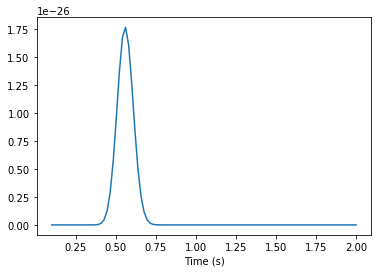

0.6201010101010099 0.00224312825221916


In [70]:
time = np.linspace(0.1,2,100)
probs, pf, fish = produce_probs_fish(k_connected(2),0)
np.random.seed(10)
data = []
multiple_mlf = []
for j in range(30):
    M = produce_data(pf, 100, pi/5)
    mlf = MLF(pf, M)
    mlf_array = []
    if j == 0:
        mlf_array = []
        for y in time:
            mlf_array.append(sym.re(mlf.evalf(subs={t:y})))

        plt.plot(time,mlf_array)
        plt.xlabel('Time (s)')
        plt.show()
    for y in time:
        mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
    multiple_mlf.append(mlf_array)
    max_vals = get_max_2(mlf,time)
    data.append(max_vals)
mean = np.mean(data)
var = np.var(data)
print(mean,var)

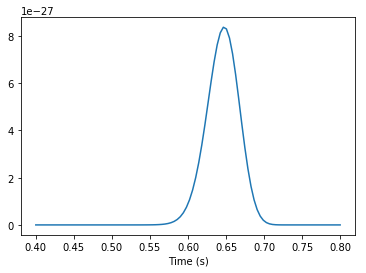

0.6311111111111111 0.0004433833282318133


In [72]:
time = np.linspace(0.4,0.8,100)
probs, pf, fish = produce_probs_fish(k_connected(8),0)
np.random.seed(10)
data = []
multiple_mlf = []
for j in range(30):
    M = produce_data(pf, 100, pi/5)
    mlf = MLF(pf, M)
    mlf_array = []
    if j == 0:
        mlf_array = []
        for y in time:
            mlf_array.append(sym.re(mlf.evalf(subs={t:y})))

        plt.plot(time,mlf_array)
        plt.xlabel('Time (s)')
        plt.show()
    for y in time:
        mlf_array.append(sym.re(mlf.evalf(subs={t:y})))
    multiple_mlf.append(mlf_array)
    max_vals = get_max_2(mlf,time)
    data.append(max_vals)
mean = np.mean(data)
var = np.var(data)
print(mean,var)

In [20]:
time = np.linspace(0,4*np.pi,400)

H = k_connected(8)

N = len(H)
np.random.seed(10)
probs, pf, fish = produce_probs_fish(H, 0)

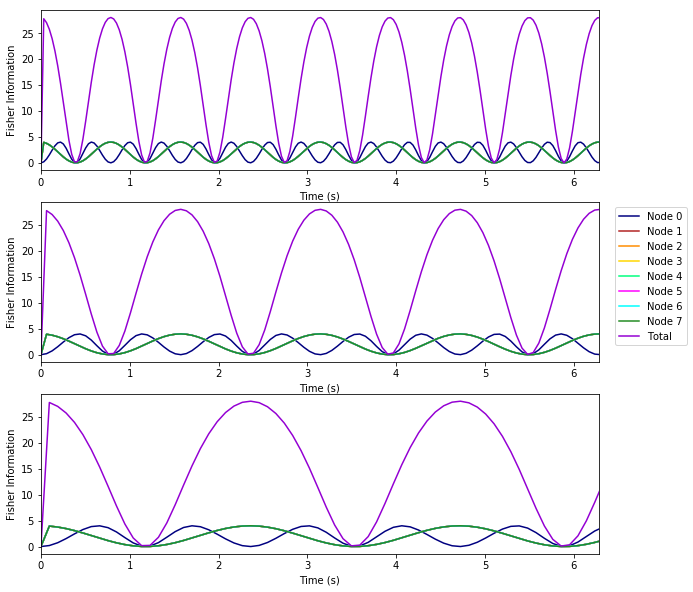

In [27]:
fig, ax = plt.subplots(3, figsize=(10,10))

time2 = np.linspace(0,4*np.pi*2,400)
time3 = np.linspace(0,4*np.pi*3,400)

for i in range(N):
    ax[0].plot(time, fish[i], label = f'Node {i}', c=C[i])
    ax[1].plot(time2, fish[i], label = f'Node {i}', c=C[i])
    ax[2].plot(time3, fish[i], label = f'Node {i}', c=C[i])

ax[0].set(xlabel='Time (s)', ylabel='Fisher Information')
ax[0].plot(time, np.sum(fish, axis=0), label ="Total", c='darkviolet')
ax[0].set_xlim(0,2*np.pi)
ax[1].set(xlabel='Time (s)', ylabel='Fisher Information')
ax[1].plot(time2, np.sum(fish, axis=0), label ="Total", c='darkviolet')
ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax[1].set_xlim(0,2*np.pi)
ax[2].set(xlabel='Time (s)', ylabel='Fisher Information')
ax[2].plot(time3, np.sum(fish, axis=0), label ="Total", c='darkviolet')
ax[2].set_xlim(0,2*np.pi)

plt.show()